## Project 4: Exploring the UK's milk imports and exports

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of milk and cream in 2020:

- How much does the UK export and import and is the balance positive (more exports than imports)? 
- Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
- Which are the regular customers, i.e. which countries buy milk from the UK every month?
- Which countries does the UK both import from and export to?

In [53]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: January to May of 2015
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

In [54]:
LOCATION = 'comtrade_milk_uk_jan_jul_20.csv'

In [36]:
milk = read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,Reporter ISO,Partner Code,Partner,Commodity Code,Commodity,Netweight (kg),Trade Value (US$),Flag
268,HS,2020,202006,Jun-20,4,0,1,Imports,826,United Kingdom,NaN,56,Belgium,401,Milk and cream; not concentrated nor containin...,274286,252633,0
269,HS,2020,202006,Jun-20,4,0,2,Exports,826,United Kingdom,NaN,203,Czech Rep.,401,Milk and cream; not concentrated nor containin...,9135,14482,0


The data only covers the first five months of 2015. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [37]:
def milkType(code):
    if code == '0401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '0402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,202001,Netherlands,Exports,unknown,505945
1,202001,Switzerland,Exports,unknown,3048
2,202001,United States of America,Exports,unknown,148700
3,202001,France,Exports,unknown,940447
4,202006,Ireland,Exports,unknown,21164834


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [55]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,202001,Netherlands,Exports,unknown,505945
1,202001,Switzerland,Exports,unknown,3048
2,202001,United States of America,Exports,unknown,148700
3,202001,France,Exports,unknown,940447
4,202006,Ireland,Exports,unknown,21164834


## Total trade flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [39]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    127176441
Imports     60378436
Name: Trade Value (US$), dtype: int64

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [40]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The UK imports from 21 countries.
The 5 biggest exporters to the UK are:


Partner
Ireland        26420537
Germany         8907935
Belgium         6874949
Netherlands     6367687
France          5108510
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

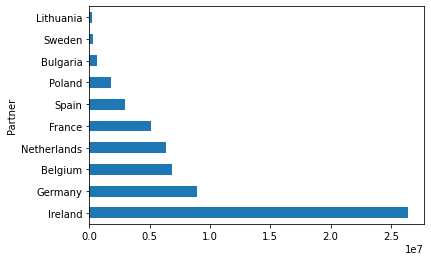

In [41]:
totalImports.head(10).plot(kind='barh')

In [42]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

The UK exports to 85 countries.
The 5 biggest importers from the UK are:


Partner
Ireland        49530260
Netherlands    20410998
China           9079482
Algeria         5887499
Germany         4859628
Name: Trade Value (US$), dtype: int64

## Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [52]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 202001) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)


In [50]:
regular[VALUE].sum() / exports[VALUE].sum()

0.0

## Bi-directional trade

To address the fourth question, 
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [56]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Algeria,5887499.0,NaN
Antigua and Barbuda,26654.0,NaN
Australia,603134.0,NaN
Austria,207514.0,226085.0
Bahrain,225538.0,NaN


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [46]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Austria,207514.0,226085.0
Belgium,3451989.0,6874949.0
Bulgaria,89.0,609826.0
Czech Rep.,43224.0,6218.0
Denmark,369533.0,48604.0
France,4290074.0,5108510.0
Germany,4859628.0,8907935.0
Greece,59567.0,150817.0
Hungary,52524.0,119470.0


## Conclusions

The milk and cream trade of the UK from January to June 2020 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a trade surplus of over 100 million US dollars.

Ireland is the main partner, but it imported from the UK almost the triple in value than it exported to the UK. 

The UK exported to over 100 countries during the period, but only imported from 21 countries, the main ones (top five by trade value) being geographically close. China and Hong Kong are the main importers that are not also main exporters. 

The UK is heavily dependent on its regular customers, the 16 countries that buy all types of milk and cream every month. They contribute three quarters of the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 20 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.

